In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# Save plots to the "plots" folder
save_path = "plots"
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Load data
resistance_vals = pd.read_csv("data/measurement_resistance.csv")
measurement_activity = pd.read_csv("data/measurement_activity.csv")
viability_metrics = pd.read_csv("data/viability_metrics.csv")
well_avgs = pd.read_csv("data/well_avgs.csv")
electrode_burst = pd.read_csv("data/electrode_bursts.csv")
measurement_electrode_burst = pd.read_csv("data/measurement_electrode_burst.csv")  

In [10]:
# Function to adjust MFR based on active electrodes
def adjusted_mfr(mfr, total_electrodes, active_electrodes):
    return (mfr * total_electrodes) / active_electrodes

# Adjust and plot MFR based on electrode_bursts, well_avgs, and measurement_activity
def plot_adjusted_mfr(measurement_activity, well_avgs, mfr_column='mean_firing_rate', electrode_column='Well', save_path=None):
  
    # Total number of electrodes 
    total_electrodes = measurement_activity[electrode_column].nunique()

    # Get MFR data from both measurement_activity and well_avgs
    # Adjusted MFR based on well data
    well_data = well_avgs[['well_id', 'num_spikes', 'mfr', 'isi_coeff', 'num_active_electrodes', 'weighted_mfr']]

    # Weighted MFR from electrode data
    well_avg_mfr = well_data['weighted_mfr'].mean()

    # Adjusted MFR for each electrode (measurement_activity)
    electrode_data = measurement_activity[['Well', 'num_spikes', mfr_column, 'isi_coeff']]

    # MFR across electrodes
    mfr_electrode = electrode_data[mfr_column].mean()

    # Adjusted MFR for both well and electrode data
    active_electrodes = len(measurement_activity[electrode_column].unique())
    
    # Total adjusted MFRs
    mfr_adjusted_electrode = adjusted_mfr(mfr_electrode, total_electrodes, active_electrodes)
    mfr_adjusted_well = adjusted_mfr(well_avg_mfr, len(well_avgs), len(well_data['num_active_electrodes'].dropna()))

    # Plotting
    plt.bar(['Electrode Level', 'Well Level'], [mfr_adjusted_electrode, mfr_adjusted_well], label=['Adjusted MFR (Electrode Level)', 'Adjusted MFR (Well Level)'])
    
    plt.ylabel("Adjusted Mean Firing Rate")
    plt.title("Adjusted Mean Firing Rate (Electrode vs Well Level)")
    plt.legend()

    
    return mfr_adjusted_electrode, mfr_adjusted_well

In [11]:
def get_active_electrodes(resistance, electrode_bursts):
    # Calculate the resistance threshold -> mean of the 'Resistance' column
    resistance_threshold = resistance['Resistance'].mean()
    
    # Merge the resistance and electrode_bursts data on the 'Electrode' column
    merged_data = electrode_bursts.merge(resistance, on='Electrode', how='inner')
    
    # Find active electrodes based on num_bursts, avg_burst_duration, and resistance threshold
    active_electrodes = merged_data[
        (merged_data['num_bursts'] > 0) & 
        (merged_data['avg_burst_duration'] > 0)  
        #(merged_data['Resistance'] > resistance_threshold)
    ]
    
    return active_electrodes

In [12]:
# Function to generate a map for either firing rate or viability
def generate_map(viability_metrics, resistance_vals, measurement_activity, map_type='firing_rate', save_path=None):
    # Get the name of the first column in each dataframe
    first_column_resistance = resistance_vals.columns[0]
    first_column_activity = measurement_activity.columns[0]
    
    # Ensure the required columns are present
    if first_column_resistance not in resistance_vals.columns:
        raise KeyError(f"'{first_column_resistance}' column missing in resistance_vals")
    if first_column_activity not in measurement_activity.columns:
        raise KeyError(f"'{first_column_activity}' column missing in measurement_activity")
    
    # Merge the measurement_activity with resistance_vals on the first column to combine firing rate and resistance
    merged_data = measurement_activity.merge(resistance_vals, left_on=first_column_activity, right_on=first_column_resistance, how='inner')

    # Handle the map_type selection
    if map_type == 'firing_rate':
        # Use the 'mean_firing_rate' from the merged data for the map
        metric = merged_data['mean_firing_rate']
        ylabel = 'Mean Firing Rate'
        
    elif map_type == 'viability':
        # Use the 'Resistance' from the merged data for the map
        metric = merged_data['Resistance']
        ylabel = 'Resistance'
        
    else:
        raise ValueError("map_type must be either 'firing_rate' or 'viability'")
    
    # Plotting the map (either firing rate or resistance)
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_data[first_column_activity], metric, c=metric, cmap='viridis', marker='s')
    plt.colorbar(label=f"{map_type.capitalize()} Metric")
    plt.xlabel(first_column_activity)
    plt.ylabel(ylabel)
    plt.title(f"{first_column_activity} {map_type.capitalize()} Map")
    
    
    #plt.savefig(save_path)
    
    plt.close()

In [13]:
# Function to generate individual 8x8 heatmaps for each well in a 6-well plate
def generate_individual_well_heatmaps(resistance_vals, map_type, save_path=None):
    """
    Generates individual 8x8 heatmaps for each well in a 6-well plate.

    Parameters:
        resistance_vals (DataFrame): DataFrame containing columns 'Electrode' and the metric column (e.g., 'Resistance').
        map_type (str): The metric to plot (e.g., 'Resistance').
        save_path (str): Directory to save the heatmap images (optional).
    """
    # Create an 8x8 grid for each well
    grid_rows, grid_cols = 8, 8
    wells = ['A1', 'A2', 'A3', 'B1', 'B2', 'B3']

    # Create a directory for saving if save_path is provided
    if save_path and not os.path.exists(save_path):
        os.makedirs(save_path)

    for well in wells:
        # Initialize grid for the current well
        grid_data = np.zeros((grid_rows, grid_cols))

        # Filter data for the current well
        well_data = resistance_vals[resistance_vals['Electrode'].str.startswith(well)]
        
        for _, row in well_data.iterrows():
            electrode = row['Electrode']
            metric_value = row[map_type]

            try:
                # Parse electrode position within the well
                _, position = electrode.split('_')
                pos_row, pos_col = divmod(int(position) - 1, grid_cols)  # Convert to grid indices
                grid_data[pos_row, pos_col] = metric_value
            except (ValueError, IndexError):
                print(f"Skipping invalid electrode format: {electrode}")
                continue

        # Plot the heatmap for the current well
        plt.figure(figsize=(6, 6))
        heatmap = plt.imshow(
            grid_data, cmap='viridis', interpolation='nearest',
            vmin=np.min(resistance_vals[map_type]), vmax=np.max(resistance_vals[map_type])
        )
        plt.colorbar(heatmap, label=f"{map_type.capitalize()} Metric")
        plt.title(f"{well} {map_type.capitalize()} Heatmap")
        plt.xlabel("Columns")
        plt.ylabel("Rows")

        # Customize ticks to match electrode layout
        plt.xticks(ticks=np.arange(grid_cols), labels=[f"{i + 1}" for i in range(grid_cols)])
        plt.yticks(ticks=np.arange(grid_rows), labels=[f"{chr(65 + i)}" for i in range(grid_rows)])  # A, B, C...
        plt.grid(color='black', linestyle='-', linewidth=0.5)

        # Save the plot if a path is provided
        # if save_path:
        #     plt.savefig(os.path.join(save_path, f"{well}_{map_type}_heatmap.png"))
        
        plt.show()

In [14]:
# Function to generate a heatmap for a 6-well plate (2x3 layout) with 8x8 grids for each well
def generate_6_well_heatmap(resistance_vals, map_type, save_path=None):
    """
    Generates a heatmap for a 6-well plate (2x3 layout) with 8x8 grids for each well.

    Parameters:
        resistance_vals (DataFrame): DataFrame containing columns 'Electrode' and the metric column (e.g., 'Resistance').
        map_type (str): The metric to plot (e.g., 'Resistance').
        save_path (str): Directory to save the heatmap image (optional).
    """
    # Define the grid size for a single well
    single_well_rows, single_well_cols = 8, 8
    
    # Define the layout of the 6-well plate (2 rows, 3 columns of wells)
    plate_rows, plate_cols = 2, 3
    total_rows, total_cols = plate_rows * single_well_rows, plate_cols * single_well_cols

    # Initialize the full grid for the 6-well plate
    full_grid = np.zeros((total_rows, total_cols))
    
    # Map well positions to their grid locations
    well_map = {
        'A1': (0, 0), 'A2': (0, 1), 'A3': (0, 2),  # Top row of wells
        'B1': (1, 0), 'B2': (1, 1), 'B3': (1, 2)   # Bottom row of wells
    }
    
    # Populate the full grid with data from each well
    for _, row in resistance_vals.iterrows():
        electrode = row['Electrode']
        metric_value = row[map_type]
        
        try:
            well_id, position = electrode.split('_')
            pos_row, pos_col = divmod(int(position) - 1, single_well_cols)  # Convert to single-well grid indices
            
            # Calculate the full grid indices
            well_row, well_col = well_map[well_id]
            full_row = well_row * single_well_rows + pos_row
            full_col = well_col * single_well_cols + pos_col
            
            full_grid[full_row, full_col] = metric_value
        except (ValueError, IndexError, KeyError):
            print(f"Skipping invalid electrode format or unknown well: {electrode}")
            continue

    # Plot the heatmap
    plt.figure(figsize=(12, 8))  # Adjust size to fit all wells
    heatmap = plt.imshow(
        full_grid, cmap='viridis', interpolation='nearest',
        vmin=np.min(full_grid), vmax=np.max(full_grid)  # Dynamic range
    )
    plt.colorbar(heatmap, label=f"{map_type.capitalize()} Metric")
    plt.title(f"6-Well Plate {map_type.capitalize()} Heatmap")
    plt.xlabel("Columns")
    plt.ylabel("Rows")

    # Add gridlines and customize ticks
    for i in range(plate_rows + 1):
        plt.axhline(i * single_well_rows - 0.5, color='black', linewidth=1)
    for j in range(plate_cols + 1):
        plt.axvline(j * single_well_cols - 0.5, color='black', linewidth=1)

    # Save the plot if a path is provided
    if save_path:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        plt.savefig(os.path.join(save_path, f"{map_type}_6_well_heatmap.png"))

    plt.show()

    Electrode  num_bursts  avg_burst_duration  avg_num_spikes  mean_isi  \
133     A3_16           1            0.192080        5.000000  0.048020   
134     A3_17           6            0.252827        5.666667  0.053788   
136     A3_21           4            0.256240        5.250000  0.060733   
181     A3_76           3            0.452240       13.000000  0.037254   

     median_isi  median_mean_isi     ibi_avg  burst_freq  ibi_coeff  \
133    0.041080         0.855477    0.000000    0.003367   0.000000   
134    0.054587         1.013310   30.997728    0.020202   1.458765   
136    0.065840         1.095066   22.878933    0.013468   0.453913   
181    0.035160         0.951412  113.959080    0.010101   1.129034   

     norm_dur_iqr  burst_percent  Resistance  
133      0.000000      11.363636   54.427242  
134      0.499195      20.987654   54.958486  
136      0.038774      12.727273   43.302110  
181      0.010101       0.000000   51.808085  
Skipping invalid electrode format

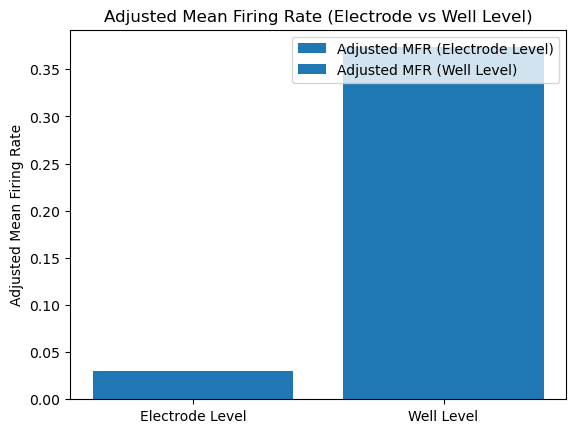

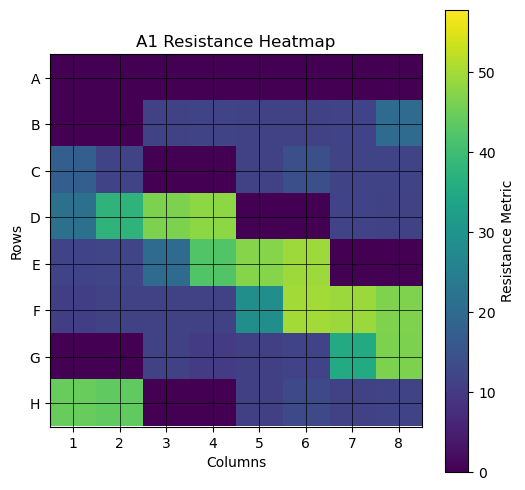

Skipping invalid electrode format: A2_65
Skipping invalid electrode format: A2_66
Skipping invalid electrode format: A2_67
Skipping invalid electrode format: A2_68
Skipping invalid electrode format: A2_71
Skipping invalid electrode format: A2_72
Skipping invalid electrode format: A2_73
Skipping invalid electrode format: A2_74
Skipping invalid electrode format: A2_75
Skipping invalid electrode format: A2_76
Skipping invalid electrode format: A2_77
Skipping invalid electrode format: A2_78
Skipping invalid electrode format: A2_81
Skipping invalid electrode format: A2_82
Skipping invalid electrode format: A2_83
Skipping invalid electrode format: A2_84
Skipping invalid electrode format: A2_85
Skipping invalid electrode format: A2_86
Skipping invalid electrode format: A2_87
Skipping invalid electrode format: A2_88


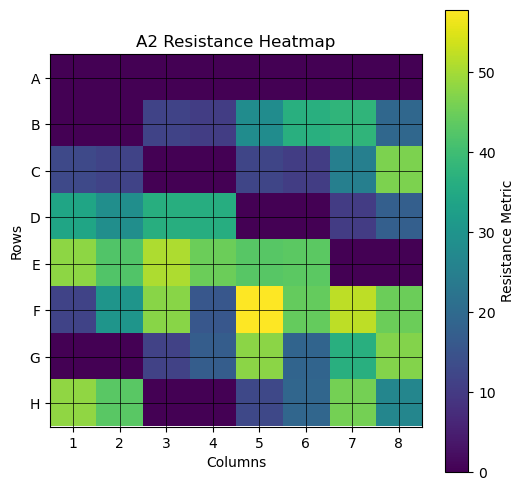

Skipping invalid electrode format: A3_65
Skipping invalid electrode format: A3_66
Skipping invalid electrode format: A3_67
Skipping invalid electrode format: A3_68
Skipping invalid electrode format: A3_71
Skipping invalid electrode format: A3_72
Skipping invalid electrode format: A3_73
Skipping invalid electrode format: A3_74
Skipping invalid electrode format: A3_75
Skipping invalid electrode format: A3_76
Skipping invalid electrode format: A3_77
Skipping invalid electrode format: A3_78
Skipping invalid electrode format: A3_81
Skipping invalid electrode format: A3_82
Skipping invalid electrode format: A3_83
Skipping invalid electrode format: A3_84
Skipping invalid electrode format: A3_85
Skipping invalid electrode format: A3_86
Skipping invalid electrode format: A3_87
Skipping invalid electrode format: A3_88


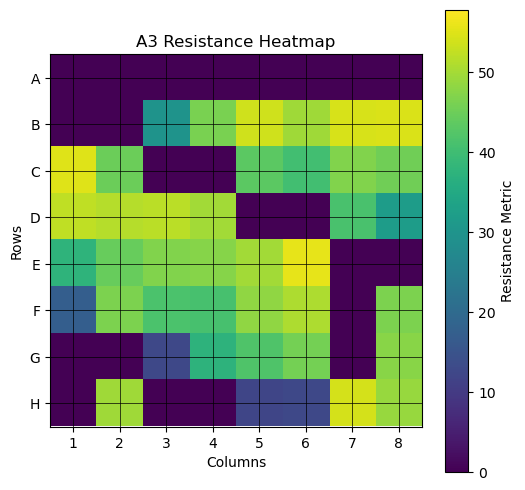

Skipping invalid electrode format: B1_65
Skipping invalid electrode format: B1_66
Skipping invalid electrode format: B1_67
Skipping invalid electrode format: B1_68
Skipping invalid electrode format: B1_71
Skipping invalid electrode format: B1_72
Skipping invalid electrode format: B1_73
Skipping invalid electrode format: B1_74
Skipping invalid electrode format: B1_75
Skipping invalid electrode format: B1_76
Skipping invalid electrode format: B1_77
Skipping invalid electrode format: B1_78
Skipping invalid electrode format: B1_81
Skipping invalid electrode format: B1_82
Skipping invalid electrode format: B1_83
Skipping invalid electrode format: B1_84
Skipping invalid electrode format: B1_85
Skipping invalid electrode format: B1_86
Skipping invalid electrode format: B1_87
Skipping invalid electrode format: B1_88


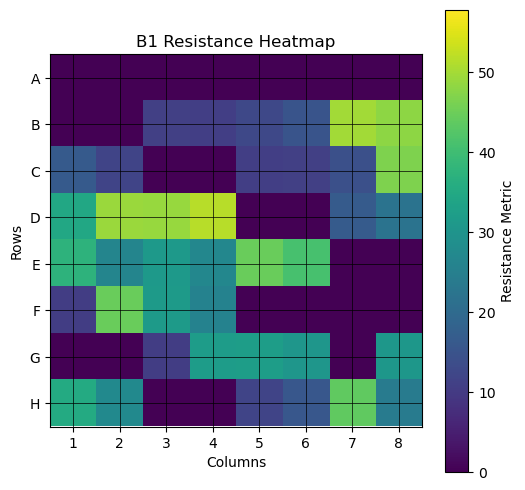

Skipping invalid electrode format: B2_65
Skipping invalid electrode format: B2_66
Skipping invalid electrode format: B2_67
Skipping invalid electrode format: B2_68
Skipping invalid electrode format: B2_71
Skipping invalid electrode format: B2_72
Skipping invalid electrode format: B2_73
Skipping invalid electrode format: B2_74
Skipping invalid electrode format: B2_75
Skipping invalid electrode format: B2_76
Skipping invalid electrode format: B2_77
Skipping invalid electrode format: B2_78
Skipping invalid electrode format: B2_81
Skipping invalid electrode format: B2_82
Skipping invalid electrode format: B2_83
Skipping invalid electrode format: B2_84
Skipping invalid electrode format: B2_85
Skipping invalid electrode format: B2_86
Skipping invalid electrode format: B2_87
Skipping invalid electrode format: B2_88


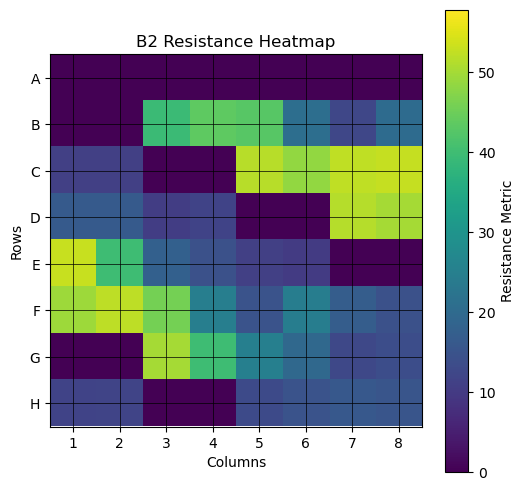

Skipping invalid electrode format: B3_65
Skipping invalid electrode format: B3_66
Skipping invalid electrode format: B3_67
Skipping invalid electrode format: B3_68
Skipping invalid electrode format: B3_71
Skipping invalid electrode format: B3_72
Skipping invalid electrode format: B3_73
Skipping invalid electrode format: B3_74
Skipping invalid electrode format: B3_75
Skipping invalid electrode format: B3_76
Skipping invalid electrode format: B3_77
Skipping invalid electrode format: B3_78
Skipping invalid electrode format: B3_81
Skipping invalid electrode format: B3_82
Skipping invalid electrode format: B3_83
Skipping invalid electrode format: B3_84
Skipping invalid electrode format: B3_85
Skipping invalid electrode format: B3_86
Skipping invalid electrode format: B3_87
Skipping invalid electrode format: B3_88


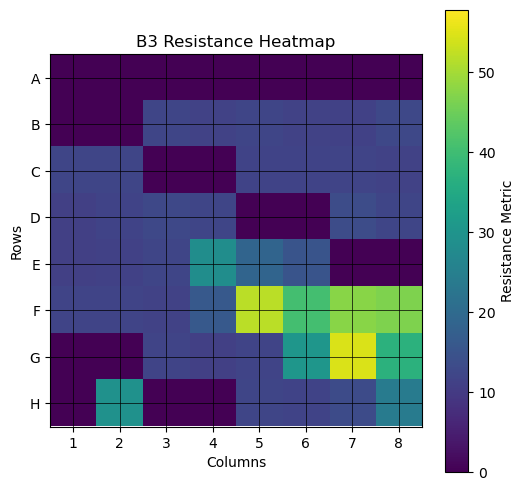

Skipping invalid electrode format or unknown well: B1_65
Skipping invalid electrode format or unknown well: B1_66
Skipping invalid electrode format or unknown well: B1_67
Skipping invalid electrode format or unknown well: B1_68
Skipping invalid electrode format or unknown well: B1_71
Skipping invalid electrode format or unknown well: B1_72
Skipping invalid electrode format or unknown well: B1_73
Skipping invalid electrode format or unknown well: B1_74
Skipping invalid electrode format or unknown well: B1_75
Skipping invalid electrode format or unknown well: B1_76
Skipping invalid electrode format or unknown well: B1_77
Skipping invalid electrode format or unknown well: B1_78
Skipping invalid electrode format or unknown well: B1_81
Skipping invalid electrode format or unknown well: B1_82
Skipping invalid electrode format or unknown well: B1_83
Skipping invalid electrode format or unknown well: B1_84
Skipping invalid electrode format or unknown well: B1_85
Skipping invalid electrode form

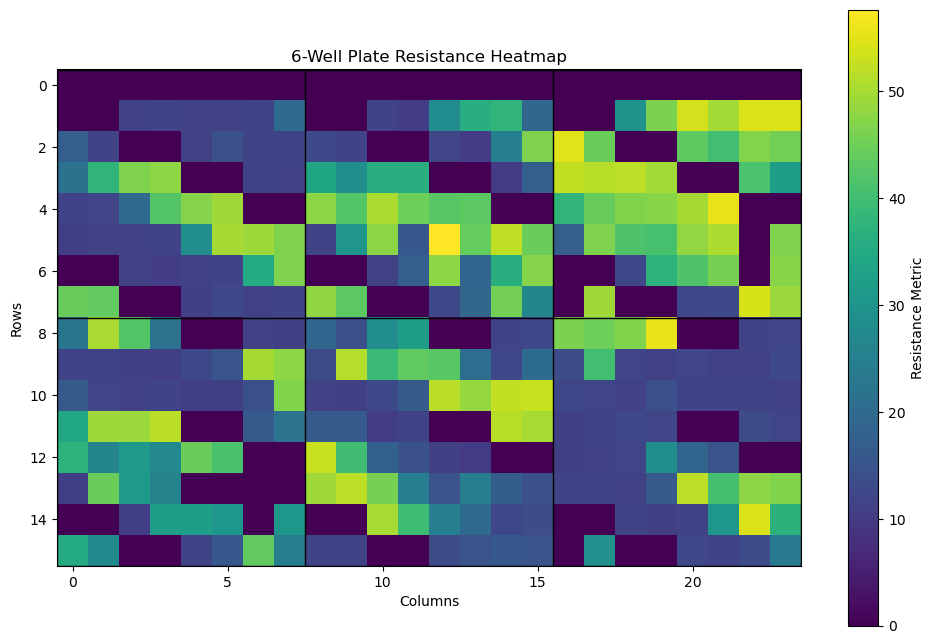

In [15]:
# execute mfr plot
adjusted_mfr_results = plot_adjusted_mfr(measurement_activity, well_avgs, save_path=save_path)  # Fixed 'neural_metrics' to 'activity'

# execute active electrodes
active_electrodes = get_active_electrodes(resistance_vals, measurement_electrode_burst) #resistance vals between 11-50, so get mean of these values for threshold
print(active_electrodes)

# generate firing rate map 
generate_map(viability_metrics, resistance_vals, measurement_activity, map_type='firing_rate', save_path=save_path)

# generate resistance map
#generate_map(viability_metrics, resistance_vals, measurement_activity, map_type='viability', save_path=save_path)

# individual well heatmaps
generate_individual_well_heatmaps(resistance_vals, map_type='Resistance', save_path=save_path + '/heatmaps/')

# 6-well heatmap
generate_6_well_heatmap(resistance_vals, map_type='Resistance', save_path=save_path + '/heatmaps/')